# MultiDVPS: Depth-Aware Video Panoptic Segmentation

This notebook demonstrates the use of the MultiDVPS model. We start by loading some checkpoint, then visualize aspects
of the outputs during both traning and inference.

In [6]:
import unipercept as up
import unimodels.multidvps as multidvps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
config = up.read_config('../configs/cityscapes/multidvps_resnet50.py')
dataset, info = up.prepare_dataset(config, "pretrain", return_loader=False)

for _ in range(3):
    inputs =next(dataset)
    up.render.utils.plot_input_data(inputs[0], info=info)
pass

2023-11-21 17:32:26 📝 unipercept.data    : Wrapping dataset: CityscapesDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='train', root='//datasets/cityscapes')


/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/utils/config/_lazy.py:198: UserWarning: No pseudo motion is added when frames=1
  return cls(**cfg)


2023-11-21 17:32:34 📝 unipercept.data    : Wrapping dataset: CityscapesDataset(queue_fn=GroupAdjacentTime(num_frames=1, use_typecheck=False), split='train', root='//datasets/cityscapes')


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/ops.py", line 313, in __getitem__
    inputs = self._set[idx]
             ~~~~~~~~~^^^^^
  File "/gpfs/home3/kstolle/projects/unicore/sources/unicore/utils/dataset.py", line 384, in __getitem__
    return self._load_fn(key, item, self._info)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/sets/_base.py", line 637, in _load_data
    data_caps = cls._load_capture_data(item_caps, info)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/sets/_base.py", line 603, in _load_capture_data
    depths=multi_read(read_depth_map, "depth", no_entries="none")(sources),
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/tensors/helpers.py", line 183, in wrapped
    item_obj = item_reader(*args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/site-packages/typing_extensions.py", line 2360, in wrapper
    return arg(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/io/_read.py", line 57, in read_depth_map
    return DepthMap.read(path, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/data/tensors/_depth.py", line 44, in read
    match DepthFormat(format):  # type: ignore
          ^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/enum.py", line 712, in __call__
    return cls.__new__(cls, value)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kstolle/.conda/envs/unipercept/lib/python3.11/enum.py", line 1128, in __new__
    raise ve_exc
ValueError: 'disparity_int16' is not a valid DepthFormat


In [2]:
model: multidvps.MultiDVPS = up.create_model(config)
print(model)

2023-11-21 17:24:07 📝 unipercept.trainer : Initializing Trainer: multidvps @ cityscapes/resnet50/2023-11-21_17-23-55@gcn14.local.snellius.surf.nl
2023-11-21 17:24:07 📝 unipercept.trainer : Using directory: /gpfs/work4/0/einf5438/outputs/multidvps/cityscapes/resnet50/2023-11-21_17-23-55@gcn14.local.snellius.surf.nl


2023-11-21 17:24:07 📝 unipercept.trainer : Current process: 1 / 1
Could not recover model from training session: FileNotFoundError(2, 'No such file or directory')
MultiDVPS(
  (backbone): FeaturePyramidNetwork(
    (bottom_up): TimmBackbone(
      (normalize): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
      (ext): FeatureGraphNet(
        (graph_module): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Module(
            (0): Module(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): ReLU(inpla

## Parameter count

We count the model parameters for each submodule.

In [3]:
def get_parameter_count(module: nn.Module) -> tuple[int,int]:
    """
    Returns the number of trainable and total (including non-trainable) parameters of a module.
    """
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    total = sum(p.numel() for p in module.parameters())
    return trainable, total

def make_human_readble(num: int) -> str:
    """
    Returns the integer in a human readable format, e.g. 1000 -> 1K, 1000000 -> 1M.
    """

    for unit in ["", "k"]:
        if abs(num) < 1000.0:
            return f"{num:.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} M"

def print_param_counts(mod: nn.Module, max_depth: int, *, cur_depth=0):
    """
    Prints the number of trainable and total (including non-trainable) parameters of a module and its submodules.
    """
    if cur_depth > max_depth:
        return
    trainable, total = get_parameter_count(mod)
    if total == 0:
        return
    indent = "    " * cur_depth
    name = indent + f"- {mod.__class__.__name__}"
    spacing = max(50 - len(name), 0) * " "
    print(f"{name}{spacing} : {make_human_readble(total):10s} -> {make_human_readble(trainable):10s}")
    for submod in mod.children():
        print_param_counts(submod, max_depth, cur_depth=cur_depth+1)

print_param_counts(model, 6)

- MultiDVPS                                        : 34.05 M    -> 34.05 M   
    - FeaturePyramidNetwork                        : 24.02 M    -> 24.02 M   
        - TimmBackbone                             : 23.51 M    -> 23.51 M   
            - FeatureGraphNet                      : 23.51 M    -> 23.51 M   
                - ResNet                           : 23.51 M    -> 23.51 M   
                    - Conv2d                       : 9.41 k     -> 9.41 k    
                    - BatchNorm2d                  : 128.00     -> 128.00    
                    - Module                       : 215.81 k   -> 215.81 k  
                        - Module                   : 75.01 k    -> 75.01 k   
                        - Module                   : 70.40 k    -> 70.40 k   
                        - Module                   : 70.40 k    -> 70.40 k   
                    - Module                       : 1.22 M     -> 1.22 M    
                        - Module                   : 379.39 k   

To ensure compatability with specialized optimizers, e.g. fused adam, we list the unique parameter datatypes below.

In [4]:
unique_param_dtypes = set()
for name, param in model.cuda().named_parameters():
    unique_param_dtypes.add(param.dtype)

print(f"Unique parameter dtypes: {unique_param_dtypes}")

Unique parameter dtypes: {torch.float32}


## Training forward pass

In [5]:
ctx = model._forward_common(inputs)
print(ctx)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
truths = model.training_pipeline.true_segmentation(ctx)

print(truths)

Truths(
    insmap=Tensor(shape=torch.Size([2, 128, 256]), device=cpu, dtype=torch.int64, is_shared=False),
    semmap=Tensor(shape=torch.Size([2, 128, 256]), device=cpu, dtype=torch.int64, is_shared=False),
    stuff=TensorDict(
        fields={
            fpn.3: Stuff(
                indices=Tensor(shape=torch.Size([2, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tensor(shape=torch.Size([2, 19, 128, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                masks=Tensor(shape=torch.Size([2, 19, 32, 64]), device=cpu, dtype=torch.bool, is_shared=False),
                scoremap=Tensor(shape=torch.Size([2, 19, 32, 64]), device=cpu, dtype=torch.float32, is_shared=False),
                batch_size=torch.Size([2, 19]),
                device=None,
                is_shared=False),
            fpn.4: Stuff(
                indices=Tensor(shape=torch.Size([2, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tensor(

fpn.3
fpn.3
fpn.4
fpn.4
fpn.5
fpn.5
fpn.6
fpn.6


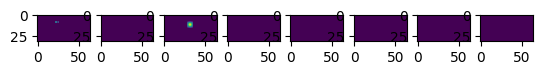

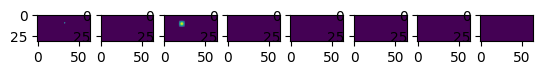

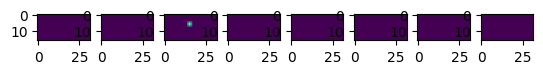

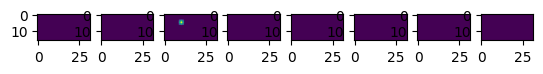

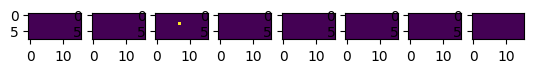

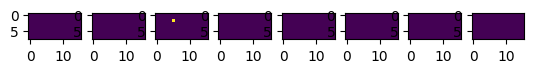

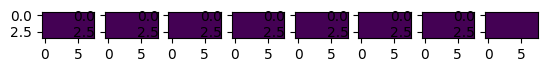

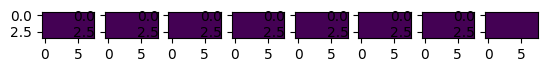

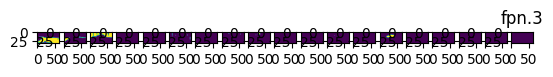

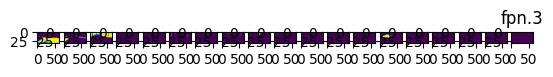

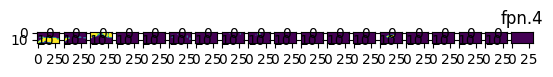

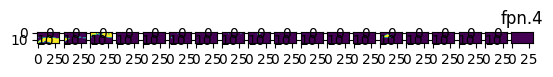

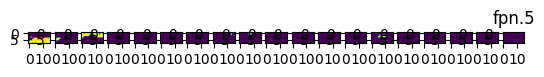

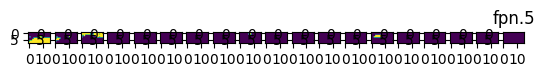

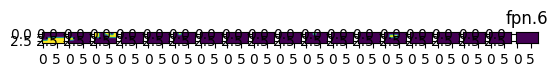

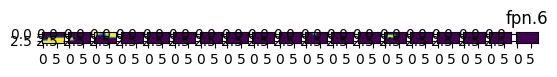

In [ ]:
for level, things in truths.thing.items():
    for things in things:
        print(level)
        
        fig, ax = plt.subplots(1, things.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(things.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
for level, stuff in truths.stuff.items():
    for stuff in stuff:
        fig, ax = plt.subplots(1, stuff.scoremap.shape[0], squeeze=False)
        for i, scoremap in enumerate(stuff.scoremap):
            ax[0, i].imshow((scoremap.cpu()))
        plt.title(level)

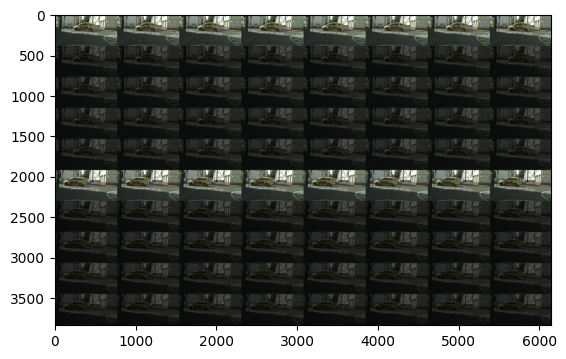

In [ ]:
vis = multidvps.visuals.visualize_true_things(ctx.captures.images, list(truths.thing.values()))
plt.imshow(vis.permute(1,2,0) / 255)

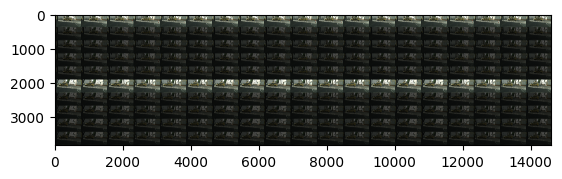

In [ ]:
vis = multidvps.visuals.visualize_true_stuff(ctx.captures.images, list(truths.stuff.values()))

plt.imshow(vis.permute(1,2,0) / vis.max())

In [17]:
import unipercept as up
import torch


with open("/home/kstolle/projects/unipercept/outputs/multidvps/cityscapes/resnet50/2023-11-21_15-39-44@gcn24.local.snellius.surf.nl/outputs/checkpoints/checkpoint_8/pytorch_model.bin", "rb") as f:
    state_dict_a = torch.load(f)

with open("/home/kstolle/projects/unipercept/outputs/multidvps/cityscapes/resnet50/2023-11-22_09-38-31@gcn24.local.snellius.surf.nl/outputs/checkpoints/checkpoint_1/pytorch_model.bin", "rb") as f:
    state_dict_b = torch.load(f)

print(state_dict_a.keys())

non_common_keys = {}
non_common_shapes = {}
for key, value in state_dict_a.items():
    if key not in state_dict_b:
        non_common_keys[key] = value
    if value.shape != state_dict_b[key].shape:
        non_common_shapes[key] = key

print(non_common_keys)
print(non_common_shapes)

non_common_keys = {}
for key, value in state_dict_b.items():
    if key not in state_dict_a:
        non_common_keys[key] = value
print(non_common_keys)

# model = up.create_model("/home/kstolle/projects/unipercept/outputs/multidvps/cityscapes/resnet50/2023-11-21_15-39-44@gcn24.local.snellius.surf.nl/outputs/checkpoints/checkpoint_8/pytorch_model.bin")

# up.load_checkpoint("/home/kstolle/projects/unipercept/outputs/multidvps/cityscapes/resnet50/2023-11-21_15-39-44@gcn24.local.snellius.surf.nl/outputs/models/step-2250/model.safetensors")

odict_keys(['backbone.bottom_up.ext.graph_module.conv1.weight', 'backbone.bottom_up.ext.graph_module.bn1.weight', 'backbone.bottom_up.ext.graph_module.bn1.bias', 'backbone.bottom_up.ext.graph_module.bn1.running_mean', 'backbone.bottom_up.ext.graph_module.bn1.running_var', 'backbone.bottom_up.ext.graph_module.bn1.num_batches_tracked', 'backbone.bottom_up.ext.graph_module.layer1.0.conv1.weight', 'backbone.bottom_up.ext.graph_module.layer1.0.bn1.weight', 'backbone.bottom_up.ext.graph_module.layer1.0.bn1.bias', 'backbone.bottom_up.ext.graph_module.layer1.0.bn1.running_mean', 'backbone.bottom_up.ext.graph_module.layer1.0.bn1.running_var', 'backbone.bottom_up.ext.graph_module.layer1.0.bn1.num_batches_tracked', 'backbone.bottom_up.ext.graph_module.layer1.0.conv2.weight', 'backbone.bottom_up.ext.graph_module.layer1.0.bn2.weight', 'backbone.bottom_up.ext.graph_module.layer1.0.bn2.bias', 'backbone.bottom_up.ext.graph_module.layer1.0.bn2.running_mean', 'backbone.bottom_up.ext.graph_module.layer1.